In [1]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Exploring Accidents

The only information source for car accidents data comes from the data collected by AUSA.<br>
AUSA is a private company that is currently the licencee for the only highway in the city of Buenos Aires.

In [2]:
path = os.path.join(os.path.dirname(os.getcwd()), 'raw_data', 'Accidentes')

os.listdir(path)

['reclamos-ausa.csv',
 'documentacion-seguridad-vial.pdf',
 'intervenciones-de-seguridad-vial.csv']

Two datasets composed by highway claims and interventions from security staff on highway.

# Highway Claims

Opening claims dataframe.

In [3]:
claims = pd.read_csv(os.path.join(path, 'reclamos-ausa.csv'))
claims.head()

,nro_caso,titulo_caso,fecha
0,C00126163,RECLAMOS/VUELTO ERRONEO/FALTANTE,2016-12-01 15:47:26
1,C00126165,RECLAMOS/DAÑO DEL VEHICULO SOBRE AU./OBJETO,2016-12-01 16:01:31
2,C00126167,RECLAMOS/DAÑO EN VIA DE PEAJE/VÍA 07 A,2016-12-01 16:13:41
3,C00126169,RECLAMOS/DAÑO DEL VEHICULO SOBRE AU./AGRESIÓN ...,2016-12-01 16:35:22
4,C00126171,QUEJAS/TELEPEAJE/DISPOSICIONES DE SERVICIO,2016-12-01 17:15:12


Claims dataset has 3 features:


- `nro_caso` case number or case ID
- `titulo_caso` case title
- `fecha` date

In [5]:
claims.titulo_caso[0].split('/')

['RECLAMOS', 'VUELTO ERRONEO', 'FALTANTE']

A closer look to `titulo_caso` column shows us that it's composed of three parts that we could call: `category`, `subcategory` and `description`.  

We'll create new features for better comprehension of the data.

In [6]:
# Lists to be populated during loop
categories = []
subcategories = []
descriptions = []

for claim in claims.titulo_caso:
    # Dividing information
    category = claim.split('/')[0]
    subcategory = claim.split('/')[1]
    description = claim.split('/')[2]
    # Inserting information into lists
    categories.append(category)
    subcategories.append(subcategory)
    descriptions.append(description)

# New features
claims['category'] = categories
claims['subcategory'] = subcategories
claims['description'] = descriptions

With the new features created there's no need to keep the original column nor the `nro_caso` column as it doesn't provide any information either.

In [7]:
claims.drop(columns=['nro_caso', 'titulo_caso'], inplace=True)

Let's take a look at the dataset now:

In [55]:
claims.columns = ['date', 'category', 'subcategory', 'description']

claims.head()

,date,category,subcategory,description
0,2016-12-01 15:47:26,RECLAMOS,VUELTO ERRONEO,FALTANTE
1,2016-12-01 16:01:31,RECLAMOS,DAÑO DEL VEHICULO SOBRE AU.,OBJETO
2,2016-12-01 16:13:41,RECLAMOS,DAÑO EN VIA DE PEAJE,VÍA 07 A
3,2016-12-01 16:35:22,RECLAMOS,DAÑO DEL VEHICULO SOBRE AU.,AGRESIÓN POR TERCEROS
4,2016-12-01 17:15:12,QUEJAS,TELEPEAJE,DISPOSICIONES DE SERVICIO


In [56]:
claims.tail()

,date,category,subcategory,description
5654,2019-04-20 10:00:21,QUEJAS,MALA ATENCION,A COMPLETAR
5655,2019-04-20 15:00:24,QUEJAS,EN GENERAL,A COMPLETAR
5656,2019-04-22 11:00:24,RECLAMOS,VUELTO ERRONEO,A COMPLETAR
5657,2019-04-23 10:30:10,QUEJAS,PEAJE,A COMPLETAR
5658,2019-04-23 10:30:20,QUEJAS,EN GENERAL,A COMPLETAR


For data consistency let's ensure everything is in *uppercase* and with no trailing whitespaces. 

In [29]:
for feature in claims:
    claims[feature] = claims[feature].str.upper().str.strip()

Let's explore the `category` feature:

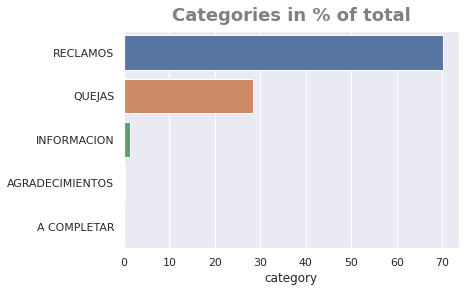

In [33]:
sns.set_theme()
plt.title('Categories in % of total', loc = 'center', size = 18, 
                pad = 10, fontweight = 'bold', color = 'gray')
ax = sns.barplot(y=claims.category.value_counts().index, x=claims.category.value_counts(normalize=True) * 100);

We can easily see that `RECLAMOS` with 70% (ie. "Demands") and `QUEJAS` with ~30% (ie. "Complaints") are the most frecuent categories.

We'll analize them separetly to get more details. 

First, we'll get into `RECLAMOS` and create a `demands` dataframe to use.

In [70]:
demands = claims[claims.category == 'RECLAMOS'].drop(columns = ['category'])
len(demands)

3965

Top 5 subcategories are almost 98% of the total demands, so let's focus on them.

In [85]:
round(demands.subcategory.value_counts().head().sum() / len(demands) *100, 2)

97.55

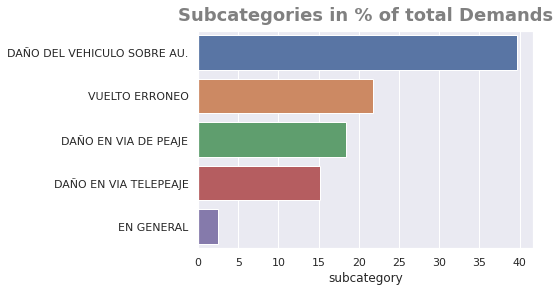

In [124]:
plt.title('Subcategories in % of total Demands', loc = 'center', size = 18, 
                pad = 10, fontweight = 'bold', color = 'gray')
sns.barplot(y=demands.subcategory.value_counts().head().index,
            x=demands.subcategory.value_counts(normalize=True).head()*100);

In [156]:
round(len(demands[demands.subcategory.str.contains('DAÑO')]) / len(demands) *100, 2)

73.32

So a little bit over 70% of the `demands` are related to `damages` ("*DAÑO..*").

Let's inspect these `damages` to see if we can get some insights.

In [136]:
print(f"""Number of possible explanations for damages: 
{demands[demands.subcategory.str.contains('DAÑO')].description.nunique()}""")

Number of possible explanations for damages: 
125


As we could imagine, there's a lot of possible explanations to these `damages`. 

Let's see if we could narrow them up using a Pareto approach:

20% of 125 is 25, so let's see how much the top 25 explanations impact on the total.

In [158]:
demands[demands.subcategory.str.contains('DAÑO')].description.value_counts().head(25).sum() / \
len(demands[demands.subcategory.str.contains('DAÑO')]) *100

79.32576539387685

In [49]:
claims[claims.category == 'QUEJAS'].subcategory.value_counts()

MALA ATENCION                     571
PEAJE                             414
SECTORES ANEXOS                   163
EN GENERAL                        153
MANTENIMIENTO DE AU DE AUSA       104
TELEPEAJE                          61
SEÑALIZACION DE AU DE AUSA         27
DISCONFORMIDAD CON EL SERVICIO     25
TELEPASE                           19
EXCEPCION DE PEAJE                 18
VUELTO ERRONEO                     18
MANTENIMIENTO                      13
CONGESTIONAMIENTO                   6
SEGURIDAD                           3
TELEPEAJE OTRAS AUTOPISTAS          3
POLICIA                             2
SEGURIDAD VIAL                      2
Name: subcategory, dtype: int64

In [6]:
reclamos['subtema'].value_counts().sort_index()

A completar                           1
A completar                           2
ACCIDENTE                             2
CONGESTIONAMIENTO                     6
DAÑO DE VEHÍCULO                      3
DAÑO DEL VEHICULO SOBRE AU.        1507
DAÑO DEL VEHICULO SOBRE AU.          65
DAÑO EN VIA DE PEAJE                701
DAÑO EN VIA DE PEAJE                 28
DAÑO EN VIA TELEPEAJE               589
DAÑO EN VIA TELEPEAJE                15
DISCONFORMIDAD CON EL SERVICIO       26
DISCONFORMIDAD CON EL SERVICIO        1
EN GENERAL                          306
EN GENERAL                           15
EXCEPCION DE PEAJE                   17
EXCEPCION DE PEAJE                    1
MALA ATENCION                       548
MALA ATENCION                        26
MANTENIMIENTO                         7
MANTENIMIENTO                         8
MANTENIMIENTO DE AU DE AUSA          90
MANTENIMIENTO DE AU DE AUSA          14
PEAJE                               445
PEAJE                                20


In [7]:
reclamos['subtema'] = reclamos['subtema'].str.strip()
reclamos['detalle'] = reclamos['detalle'].str.strip()
reclamos['subtema'].value_counts().sort_index()

A completar                          3
ACCIDENTE                            2
CONGESTIONAMIENTO                    6
DAÑO DE VEHÍCULO                     3
DAÑO DEL VEHICULO SOBRE AU.       1572
DAÑO EN VIA DE PEAJE               729
DAÑO EN VIA TELEPEAJE              604
DISCONFORMIDAD CON EL SERVICIO      27
EN GENERAL                         321
EXCEPCION DE PEAJE                  18
MALA ATENCION                      574
MANTENIMIENTO                       15
MANTENIMIENTO DE AU DE AUSA        104
PEAJE                              465
POLICIA                              2
SECTORES ANEXOS                    165
SEGURIDAD                            4
SEGURIDAD VIAL                       2
SEÑALIZACION DE AU DE AUSA          27
TELEPASE                            33
TELEPEAJE                           95
TELEPEAJE AUSA                       1
TELEPEAJE OTRAS AUTOPISTAS           4
VUELTO ERRONEO                     883
Name: subtema, dtype: int64

In [8]:
reclamos['subtema'][reclamos.subtema.str.contains('TEL')] = 'TELEPEAJE'
reclamos['subtema'][reclamos.subtema.str.contains('MANTE')] = 'MANTENIMIENTO'

In [9]:
reclamos['subtema'][reclamos.subtema.str.contains('MANTE')].value_counts()

MANTENIMIENTO    119
Name: subtema, dtype: int64

In [10]:
reclamos.subtema.value_counts()[reclamos.subtema.value_counts(normalize=True) < 0.01].sum() / len(reclamos)

0.016610708605760735

In [11]:
others = list(reclamos['subtema'].value_counts()[reclamos['subtema'].value_counts() < 10].index)
others

['CONGESTIONAMIENTO',
 'SEGURIDAD',
 'DAÑO DE VEHÍCULO',
 'A completar',
 'ACCIDENTE',
 'POLICIA',
 'SEGURIDAD VIAL']

In [12]:
reclamos['subtema'][reclamos.subtema.isin(others)] = 'OTROS'

In [13]:
reclamos.subtema.value_counts().sort_index()

DAÑO DEL VEHICULO SOBRE AU.       1572
DAÑO EN VIA DE PEAJE               729
DISCONFORMIDAD CON EL SERVICIO      27
EN GENERAL                         321
EXCEPCION DE PEAJE                  18
MALA ATENCION                      574
MANTENIMIENTO                      119
OTROS                               22
PEAJE                              465
SECTORES ANEXOS                    165
SEÑALIZACION DE AU DE AUSA          27
TELEPEAJE                          737
VUELTO ERRONEO                     883
Name: subtema, dtype: int64

In [14]:
reclamos[reclamos.tema.str.contains('a completar', case=False)].index

Int64Index([1527, 3988, 3989, 3990], dtype='int64')

In [15]:
reclamos.drop(index=reclamos[reclamos.tema.str.contains('a completar', case=False)].index, inplace=True)

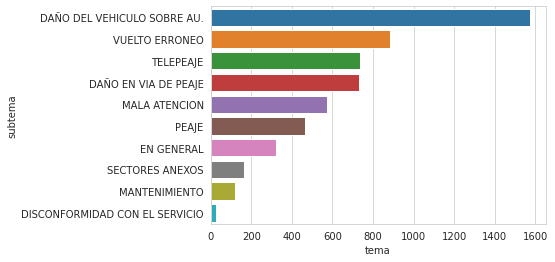

In [16]:
sns.set_style("whitegrid")
subtemas = reclamos.groupby('subtema').count().sort_values(by='tema', ascending=False).head(10)
sns.barplot(y=subtemas.index, x=subtemas.tema);

<AxesSubplot:xlabel='detalle'>

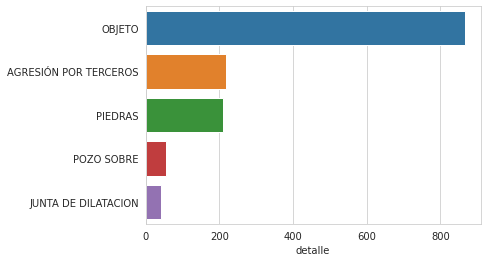

In [17]:
damages = reclamos[reclamos.subtema == 'DAÑO DEL VEHICULO SOBRE AU.'].detalle.value_counts().head()
sns.barplot(y=damages.index, x=damages)

## Accidentes

In [40]:
# Usar date parser para darle formato a las columnas de tiempo
accidents = pd.read_csv(os.path.join(path, 'intervenciones-de-seguridad-vial.csv'))
accidents.head()

,periodo,fecha,hora,autopista,banda_y_o_ramal,pk,condiciones_meteorologicas,superficie_de_la_via,lesionados,fallecidos,tipo_de_siniestro,moto,liviano,bus,camion
0,201401,2014-01-01,1,AU CAMPORA,ASCENDENTE,600,BUENO,SECA,1,0,COLISION CON OBSTACULO FIJO,0,1,0,0
1,201401,2014-01-01,3,AU DELLEPIANE,DESCENDENTE,600,BUENO,SECA,0,0,COLISION CON OBSTACULO FIJO,0,1,0,0
2,201401,2014-01-01,22,AU 25 DE MAYO,ASCENDENTE,5900,BUENO,SECA,8,0,COLISION CON DOS O MAS VEHICULOS,0,2,0,0
3,201401,2014-03-01,7,AU CAMPORA,DESCENDENTE,600,BUENO,SECA,0,0,OBSTACULO NO FIJO,0,0,0,1
4,201401,2014-03-01,21,AU PERTIO MORENO,DESCENDENTE,5400,BUENO,SECA,1,0,COLISION CON OBSTACULO FIJO,0,2,0,0


In [41]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6962 entries, 0 to 6961
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   periodo                     6962 non-null   int64 
 1   fecha                       6962 non-null   object
 2   hora                        6962 non-null   int64 
 3   autopista                   6962 non-null   object
 4   banda_y_o_ramal             6962 non-null   object
 5   pk                          6962 non-null   object
 6   condiciones_meteorologicas  6962 non-null   object
 7   superficie_de_la_via        6962 non-null   object
 8   lesionados                  6962 non-null   int64 
 9   fallecidos                  6962 non-null   int64 
 10  tipo_de_siniestro           6962 non-null   object
 11  moto                        6962 non-null   int64 
 12  liviano                     6962 non-null   int64 
 13  bus                         6962 non-null   int6

In [51]:
accidents.fecha.unique()

array(['2014-01-01', '2014-03-01', '2014-04-01', ..., '25/02/2021',
       '26/02/2021', '28/02/2021'], dtype=object)